In [ ]:
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchsummary import summary
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn import preprocessing
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
import sklearn
!CUBLAS_WORKSPACE_CONFIG=:16:8
!pip install brevitas
import brevitas.nn as qnn


# !pip install memtorch
# import memtorch
# import copy
# from memtorch.mn.Module import patch_model
# from memtorch.map.Parameter import naive_map
# from memtorch.bh.crossbar.Program import naive_program

     |████████████████████████████████| 393 kB 6.5 MB/s 


In [ ]:
from tensorflow.python.client import device_lib
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device),'\n')
print('Device Details')
print(device_lib.list_local_devices())

Using cuda device 

Device Details
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13656963298519273998
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14512029696
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1067649480123787867
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
### Data Loading ## preictal 0, interictal 1
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(42)

rootPath = '/content/drive/MyDrive/ISML/SeizurePredictionDataset/'

patients = ['01']
dataset = 'CHBMIT'
dataType = 'features'
numFold = 5
bS = 32

if dataType == 'features':
  allData = np.empty((0,176))
  rawLabel = np.empty((0,),dtype=int)

for patient in patients:
  newData = np.load(rootPath+dataType+'/'+dataset+'_'+'patient'+'_'+patient+'_'+'synthetic_preictal.npy')
  allData = np.append(allData,newData,axis=0)
  rawLabel = np.append(rawLabel,np.zeros((newData.shape[0],),dtype=int),axis=0)
  newData = np.load(rootPath+dataType+'/'+dataset+'_'+'patient'+'_'+patient+'_'+'preictal.npy')
  allData = np.append(allData,newData,axis=0)
  rawLabel = np.append(rawLabel,np.zeros((newData.shape[0],),dtype=int),axis=0)
  newData = np.load(rootPath+dataType+'/'+dataset+'_'+'patient'+'_'+patient+'_'+'interictal.npy')
  allData = np.append(allData,newData,axis=0)
  rawLabel = np.append(rawLabel,np.ones((newData.shape[0],),dtype=int),axis=0)

allLabel = np.zeros((rawLabel.size, rawLabel.max()+1))
allLabel[np.arange(rawLabel.size),rawLabel] = 1

randInd = np.arange(0,len(allData))
np.random.shuffle(randInd)
allData = allData[randInd]
allLabel = allLabel[randInd]
allData = allData[:math.floor(allData.shape[0]/5)*5]
allLabel = allLabel[:math.floor(allLabel.shape[0]/5)*5]

pca = PCA(n_components=64)
allData = pca.fit_transform(allData)

foldsData = np.split(allData,numFold)
foldsLabel = np.split(allLabel,numFold)

trainData = np.concatenate(foldsData[0:-1])
trainLabel = np.concatenate(foldsLabel[0:-1])
testData = foldsData[-1]
testLabel = foldsLabel[-1]

trainData = np.expand_dims(trainData,1)
testData = np.expand_dims(testData,1)

trainData = torch.tensor(trainData)
testData = torch.tensor(testData)
trainLabel = torch.tensor(trainLabel)
testLabel = torch.tensor(testLabel)



In [6]:
### Network Definition
class ParallelConvolution(nn.Module):
    def __init__(self,size):
        super(ParallelConvolution, self).__init__()
        self.conv1 = qnn.QuantConv1d(1,32,size,weight_bit_width=6)
        self.conv2 = qnn.QuantConv1d(1,32,62-size,weight_bit_width=6)
        self.avgpool = nn.AvgPool1d(2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.linear = qnn.QuantLinear(1088,8,bias=True,weight_bit_width=4)
        self.classification = qnn.QuantLinear(8,2,bias=True,weight_bit_width=4)

    def forward(self,x):
        out1 = F.relu(self.conv1(x))
        out2 = F.relu(self.conv2(x))
        x = torch.cat((out1, out2),dim=2)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        out = self.classification(x)
        return out
      
    

model = ParallelConvolution(27)
model = model.to(device)
#summary(model,(1,64))

In [7]:
### 5-fold Cross Validation Function
import pandas as pd
import seaborn as sns


def foldCrossValidation(patients,num_epoch=30):

  !CUBLAS_WORKSPACE_CONFIG=:16:8
  torch.manual_seed(8)
  np.random.seed(8)
  torch.backends.cudnn.benchmark = False
  torch.use_deterministic_algorithms(False)
  torch.backends.cudnn.deterministic = True
  os.environ['PYTHONHASHSEED'] = str(8)
  !CUBLAS_WORKSPACE_CONFIG=:16:8


  rootPath = '/content/drive/MyDrive/ISML/SeizurePredictionDataset/'

  dataset = 'CHBMIT'
  dataType = 'features'
  numFold = 5
  bS = 32

  if dataType == 'features':
    allData = np.empty((0,176))
    rawLabel = np.empty((0,),dtype=int)

  for patient in patients:
    newData = np.load(rootPath+dataType+'/'+dataset+'_'+'patient'+'_'+patient+'_'+'synthetic_preictal.npy')
    allData = np.append(allData,newData,axis=0)
    rawLabel = np.append(rawLabel,np.zeros((newData.shape[0],),dtype=int),axis=0)
    newData = np.load(rootPath+dataType+'/'+dataset+'_'+'patient'+'_'+patient+'_'+'preictal.npy')
    allData = np.append(allData,newData,axis=0)
    rawLabel = np.append(rawLabel,np.zeros((newData.shape[0],),dtype=int),axis=0)
    newData = np.load(rootPath+dataType+'/'+dataset+'_'+'patient'+'_'+patient+'_'+'interictal.npy')
    allData = np.append(allData,newData,axis=0)
    rawLabel = np.append(rawLabel,np.ones((newData.shape[0],),dtype=int),axis=0)

  allLabel = np.zeros((rawLabel.size, rawLabel.max()+1))
  allLabel[np.arange(rawLabel.size),rawLabel] = 1
  
  pca = PCA(n_components=64)
  allData = pca.fit_transform(allData)

  inputbits=6
  inputstep=(np.amax(allData) - np.amin(allData))/(2**inputbits-1)
  allData = np.round(allData/inputstep)
  allData *= inputstep
  
  randInd = np.arange(0,len(allData))
  np.random.shuffle(randInd)
  allData = allData[randInd]
  allLabel = allLabel[randInd]
  allData = allData[:math.floor(allData.shape[0]/5)*5]
  allLabel = allLabel[:math.floor(allLabel.shape[0]/5)*5]

  foldsData = np.split(allData,numFold)
  foldsLabel = np.split(allLabel,numFold)


  def foldretrieve(fold,foldsData,foldsLabel):
      testData = foldsData[fold]
      testLabel = foldsLabel[fold]
      allData = foldsData[0:fold]+foldsData[fold:-1]
      allLabel = foldsLabel[0:fold]+foldsLabel[fold:-1]
      trainData = np.concatenate([*allData])
      trainLabel = np.concatenate([*allLabel])

      trainData = np.expand_dims(trainData,1)
      testData = np.expand_dims(testData,1)

      trainData = torch.tensor(trainData)
      testData = torch.tensor(testData)
      trainLabel = torch.tensor(trainLabel)
      testLabel = torch.tensor(testLabel)
      return trainData,testData,trainLabel,testLabel



  ker = 32

  loss_function = nn.BCEWithLogitsLoss()



  for fold in range(0,numFold):
      trainData,testData,trainLabel,testLabel = foldretrieve(fold,foldsData,foldsLabel)

      print('--------------------------------')
      print(f'Fold Number {fold}')
      print('--------------------------------')

      network = ParallelConvolution(ker)
      network.to(device,dtype=torch.float)

      optimizer = torch.optim.Adam(network.parameters())
      
      lossHist = []
      testAccHist = []
      trainAccHist = []
      bestAcc = 0
      bestSen = 0
      bestSpe = 0
      bestFPC = 1e10
      bestAUR = 0
      bestEpoch = [0,0,0,0,0]
      for epoch in range(num_epoch):
          trainCorrect = 0
          trainTotal = 0

          testCorrect = 0
          testTotal = 0

          trainOutputs = np.empty((0,1))
          trainLabels = np.empty((0,1))
          trainCM = np.zeros((2, 2))
          
          testOutputs = np.empty((0,1))
          testLabels = np.empty((0,1))
          testCM = np.zeros((2, 2))

          for i in range(0,len(trainData),bS):
              data = trainData[i:i+bS].to(device,dtype=torch.float)
              label = trainLabel[i:i+bS].to(device,dtype=torch.float)

              # Zero the gradients
              optimizer.zero_grad()
              network.eval()
              # Perform forward pass
              outputs = network(data)
              network.train()
              # Compute loss
              loss = loss_function(outputs, label)
              
              # Perform backward pass
              loss.backward()
              
              # Perform optimization
              optimizer.step()
              network.eval()
              # # Print statistics
              # current_loss += loss.item()

              outputs = outputs.cpu().detach().numpy()
              label = label.cpu().detach().numpy()

              outputs = np.argmax(outputs,axis=1)
              label = np.argmax(label,axis=1)

              trainCM = np.add(trainCM, sklearn.metrics.confusion_matrix(outputs, label, labels=[0, 1]))

              trainCorrect += np.sum(outputs==label)
              trainTotal += len(outputs)

              trainOutputs = np.append(trainOutputs,outputs.reshape((-1,1)),axis=0)
              trainLabels = np.append(trainLabels,label.reshape((-1,1)),axis=0)

          for i in range(0,len(testData),bS):
              data = testData[i:i+bS].to(device,dtype=torch.float)
              label = testLabel[i:i+bS].to(device,dtype=torch.float)

              network.eval()
              # Perform forward pass
              outputs = network(data)
              #Caclulate statistics
              testCorrect += np.sum(np.argmax(outputs.cpu().detach().numpy(),axis=1)==np.argmax(label.cpu().detach().numpy(),axis=1))
              testTotal += len(outputs)
              #print(label)

              outputs = outputs.cpu().detach().numpy()
              label = label.cpu().detach().numpy()

              outputs = np.argmax(outputs,axis=1)
              label = np.argmax(label,axis=1)

              testCM = np.add(testCM, sklearn.metrics.confusion_matrix(outputs, label, labels=[0, 1]))

              testCorrect += np.sum(outputs==label)
              testTotal += len(outputs)

              testOutputs = np.append(testOutputs,outputs.reshape((-1,1)),axis=0)
              testLabels = np.append(testLabels,label.reshape((-1,1)),axis=0)
              
          if testCorrect/testTotal > bestAcc:
              # torch.save(network,'/content/drive/MyDrive/ISML Final Paper Files/ModelCheckpoint/'+'Fold'+str(fold)+'Epoch'+str(epoch))
              # bestAcc = testCorrect/testTotal
              torch.save(network.state_dict(),'/content/drive/MyDrive/ISML Final Paper Files/ModelCheckpointCHBMITFeaturesQAT/Patient{}Fold{}Epoch{}'.format(patients[0],fold,epoch))
              #print(network.state_dict())
              #print(testCorrect)

          trainF1 = sklearn.metrics.f1_score(trainLabels,trainOutputs)
          trainAccuracy = trainCorrect/trainTotal
          trainTN, trainFP, trainFN, trainTP = trainCM.ravel()
          trainSensitivity = trainTP / (trainTP+trainFN)
          trainSpecitivity = trainTN / (trainTN+trainFP)
          try:
            trainAUROC = sklearn.metrics.roc_auc_score(trainLabels, trainOutputs)
          except:
            trainAUROC = 0.


          trainF1 = sklearn.metrics.f1_score(trainLabels,trainOutputs)
          trainAccuracy = trainCorrect/trainTotal
          trainTN, trainFP, trainFN, trainTP = trainCM.ravel()
          trainSensitivity = trainTP / (trainTP+trainFN)
          trainSpecitivity = trainTN / (trainTN+trainFP)
          try:
            trainAUROC = sklearn.metrics.roc_auc_score(trainLabels, trainOutputs)
          except:
            trainAUROC = 0.


          testF1 = sklearn.metrics.f1_score(testLabels,testOutputs)
          testAccuracy = testCorrect/testTotal
          testTN, testFP, testFN, testTP = testCM.ravel()
          testSensitivity = testTP / (testTP+testFN)
          testSpecitivity = testTN / (testTN+testFP)
          try:
            testAUROC = sklearn.metrics.roc_auc_score(testLabels, testOutputs)
          except:
            testAUROC = 0.


          if testAccuracy > bestAcc:
            bestAcc = testAccuracy
            bestEpoch[0] = epoch
          if testSensitivity > bestSen:
            bestSen = testSensitivity
            bestEpoch[1] = epoch
          if testSpecitivity > bestSpe:
            bestSpe = testSpecitivity
            bestEpoch[2] = epoch
          if testFP < bestFPC:
            bestFPC = testFP
            bestEpoch[3] = epoch
          if testAUROC > bestAUR:
            bestAUR = testAUROC
            bestEpoch[4] = epoch

          print('Epoch:', epoch, 'Train Loss:', loss.item())
          print('Train Accuracy:', trainAccuracy, 'Train Sensitivity:', trainSensitivity, 'Train Specitivity:', trainSpecitivity, 'Train FP Count:', trainFP, 'Train AUROC:', trainAUROC)
          print('Test Accuracy:', testAccuracy, 'Test Sensitivity:', testSensitivity, 'Test Specitivity:', testSpecitivity, 'Test FP Count:', testFP, 'Test AUROC:', testAUROC,)
          print('\n')
          lossHist.append(loss)
          trainAccHist.append(trainCorrect/trainTotal)
          testAccHist.append(testCorrect/testTotal)

      plt.figure(1)
      plt.plot(np.arange(num_epoch),lossHist,label=str(ker))
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.figure(2)
      plt.plot(np.arange(num_epoch),trainAccHist,label=str(ker))
      plt.xlabel('Epoch')
      plt.ylabel('Train Accuracy')
      plt.legend()
      plt.figure(3)
      plt.plot(np.arange(num_epoch),testAccHist,label=str(ker))
      plt.xlabel('Epoch')
      plt.ylabel('Test Accuracy')
      plt.legend()
      print('Best Accuracy:', bestAcc, 'at epoch:', bestEpoch[0])
      print('Best Sensitivity:', bestSen, 'at epoch:', bestEpoch[1])
      print('Best Specitivity:', bestSpe, 'at epoch:', bestEpoch[2])
      print('Best FP Count:', bestFPC, 'at epoch:', bestEpoch[3])
      print('Best AUROC:', bestAUR, 'at epoch:', bestEpoch[4])
  return None

--------------------------------
Fold Number 0
--------------------------------
Epoch: 0 Train Loss: 146.08929443359375
Train Accuracy: 0.8273874862788145 Train Sensitivity: 0.5808270676691729 Train Specitivity: 0.8965214335910049 Train FP Count: 589.0 Train AUROC: 0.7477866033275005
Test Accuracy: 0.8962678375411636 Test Sensitivity: 0.8461538461538461 Test Specitivity: 0.9036523929471033 Test FP Count: 153.0 Test AUROC: 0.7698147082919347


Epoch: 1 Train Loss: 222.41748046875
Train Accuracy: 0.8566136114160263 Train Sensitivity: 0.6540222367560498 Train Specitivity: 0.9104011113040459 Train FP Count: 516.0 Train AUROC: 0.7839906326054082
Test Accuracy: 0.8721185510428101 Test Sensitivity: 0.6695402298850575 Test Specitivity: 0.9199457259158752 Test FP Count: 118.0 Test AUROC: 0.79281977684425


Epoch: 2 Train Loss: 47.24143600463867
Train Accuracy: 0.8833699231613611 Train Sensitivity: 0.7388809182209469 Train Specitivity: 0.9175432643366135 Train FP Count: 486.0 Train AUROC: 0.8081

KeyboardInterrupt: ignored

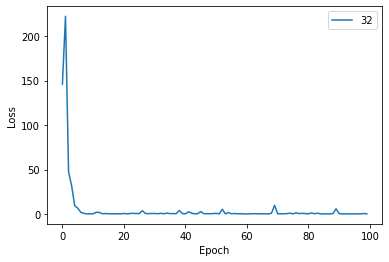

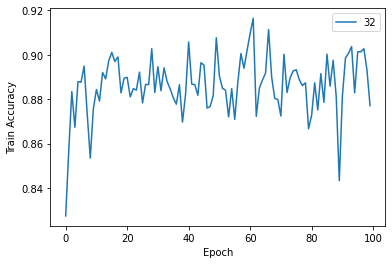

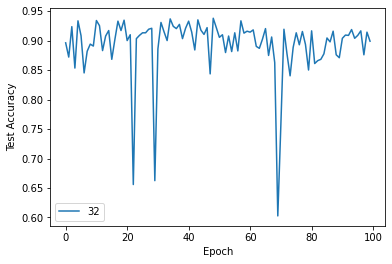

In [8]:
##Patient 01
foldCrossValidation(['01'],num_epoch=100)

--------------------------------
Fold Number 0
--------------------------------
Epoch: 0 Train Loss: 0.0
Train Accuracy: 0.9160447761194029 Train Sensitivity: 0.9596719070403281 Train Specitivity: 0.47586206896551725 Train FP Count: 76.0 Train AUROC: 0.7438555743243244
Test Accuracy: 0.9651741293532339 Test Sensitivity: 0.981029810298103 Test Specitivity: 0.7878787878787878 Test FP Count: 7.0 Test AUROC: 0.8844542990884454


Epoch: 1 Train Loss: 0.0
Train Accuracy: 0.9564676616915423 Train Sensitivity: 0.9795918367346939 Train Specitivity: 0.7101449275362319 Train FP Count: 40.0 Train AUROC: 0.8692989864864865
Test Accuracy: 0.9751243781094527 Test Sensitivity: 0.9812332439678284 Test Specitivity: 0.896551724137931 Test FP Count: 3.0 Test AUROC: 0.8898743532889873


Epoch: 2 Train Loss: 0.0
Train Accuracy: 0.9676616915422885 Train Sensitivity: 0.9824324324324324 Train Specitivity: 0.796875 Train FP Count: 26.0 Train AUROC: 0.8896537162162161
Test Accuracy: 0.8084577114427861 Test Sensi

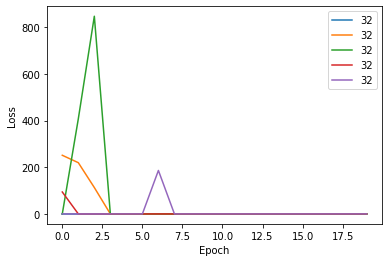

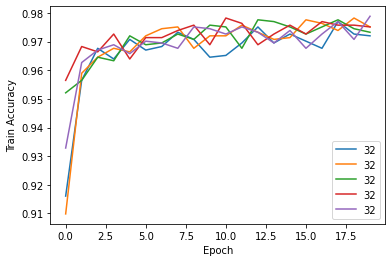

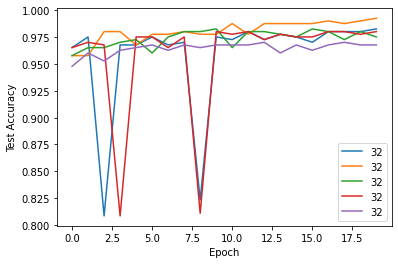

In [ ]:
##Patient 02
foldCrossValidation(['02'],num_epoch=20)

--------------------------------
Fold Number 0
--------------------------------
Epoch: 0 Train Loss: 392.033447265625
Train Accuracy: 0.8222222222222222 Train Sensitivity: 0.45491803278688525 Train Specitivity: 0.8841160220994475 Train FP Count: 839.0 Train AUROC: 0.652011105782292
Test Accuracy: 0.8458628841607565 Test Sensitivity: 0.5198776758409785 Test Specitivity: 0.9054809843400448 Test FP Count: 169.0 Test AUROC: 0.7065370126763932


Epoch: 1 Train Loss: 70.71819305419922
Train Accuracy: 0.8276595744680851 Train Sensitivity: 0.47636632200886264 Train Specitivity: 0.8945961159583451 Train FP Count: 749.0 Train AUROC: 0.6811788096735798
Test Accuracy: 0.8368794326241135 Test Sensitivity: 0.48770491803278687 Test Specitivity: 0.8824158204168894 Test FP Count: 220.0 Test AUROC: 0.6403247827473492


Epoch: 2 Train Loss: 444.3636169433594
Train Accuracy: 0.839952718676123 Train Sensitivity: 0.5149700598802395 Train Specitivity: 0.9008983717012914 Train FP Count: 706.0 Train AUROC: 0.7

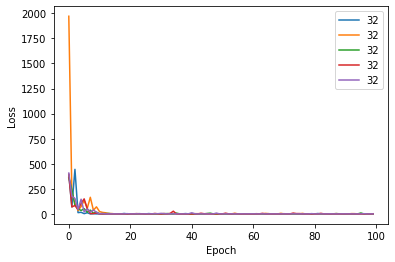

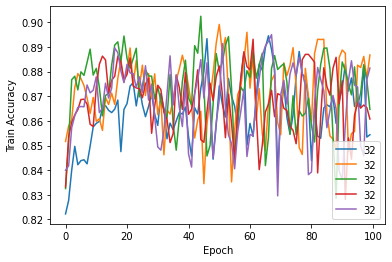

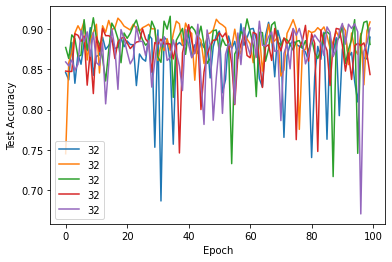

In [ ]:
##Patient 03
foldCrossValidation(['03'],num_epoch=100)

Streaming output truncated to the last 5000 lines.
Test Accuracy: 0.9152798789712556 Test Sensitivity: 0.9781021897810219 Test Specitivity: 0.898854961832061 Test FP Count: 106.0 Test AUROC: 0.8551242130914506


Epoch: 8 Train Loss: 0.6238001585006714
Train Accuracy: 0.8642208774583964 Train Sensitivity: 0.7701532311792139 Train Specitivity: 0.9015051491946131 Train FP Count: 373.0 Train AUROC: 0.8321349885193783
Test Accuracy: 0.9122541603630863 Test Sensitivity: 0.9417808219178082 Test Specitivity: 0.903883495145631 Test FP Count: 99.0 Test AUROC: 0.8586808140977911


Epoch: 9 Train Loss: 3.9772753715515137
Train Accuracy: 0.8657337367624811 Train Sensitivity: 0.768172888015717 Train Specitivity: 0.9053443233182664 Train FP Count: 356.0 Train AUROC: 0.8364970506363538
Test Accuracy: 0.9092284417549168 Test Sensitivity: 0.9810606060606061 Test Specitivity: 0.8913043478260869 Test FP Count: 115.0 Test AUROC: 0.8436195536902907


Epoch: 10 Train Loss: 10.807550430297852
Train Accuracy: 

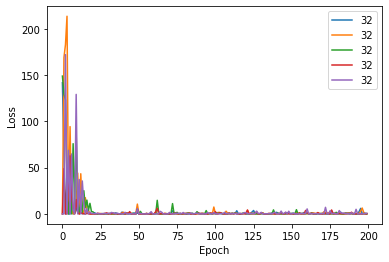

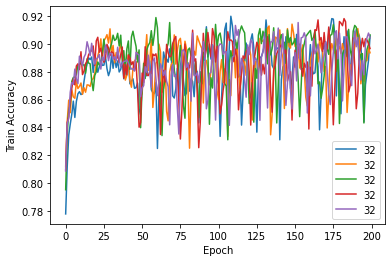

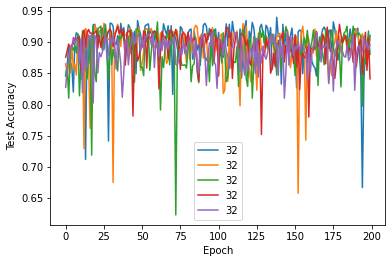

In [ ]:
##Patient 05
foldCrossValidation(['05'],num_epoch=200)

--------------------------------
Fold Number 0
--------------------------------
Epoch: 0 Train Loss: 4878.568359375
Train Accuracy: 0.7600401606425703 Train Sensitivity: 0.8272727272727273 Train Specitivity: 0.6279761904761905 Train FP Count: 125.0 Train AUROC: 0.7314708242577097
Test Accuracy: 0.8674698795180723 Test Sensitivity: 0.8629441624365483 Test Specitivity: 0.8846153846153846 Test FP Count: 6.0 Test AUROC: 0.7980230386052305


Epoch: 1 Train Loss: 4906.71875
Train Accuracy: 0.8724899598393574 Train Sensitivity: 0.9096385542168675 Train Specitivity: 0.7981927710843374 Train FP Count: 67.0 Train AUROC: 0.8577668233405938
Test Accuracy: 0.9397590361445783 Test Sensitivity: 0.96 Test Specitivity: 0.8918918918918919 Test FP Count: 8.0 Test AUROC: 0.9293275217932753


Epoch: 2 Train Loss: 2691.14501953125
Train Accuracy: 0.8714859437751004 Train Sensitivity: 0.9170506912442397 Train Specitivity: 0.7855072463768116 Train FP Count: 74.0 Train AUROC: 0.8617814971913333
Test Accuracy: 

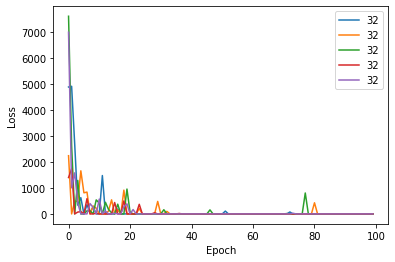

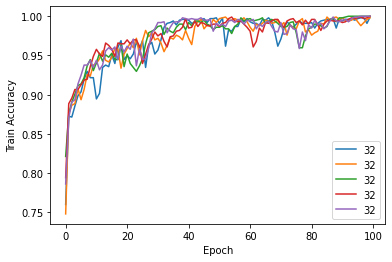

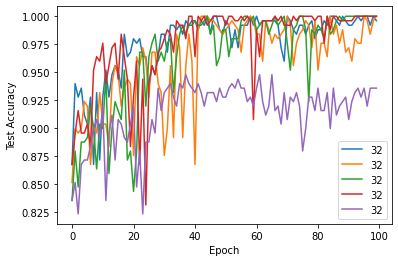

In [ ]:
##Patient 08
foldCrossValidation(['08'],num_epoch=100)